In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152, InceptionV3, DenseNet121, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import time

sns.set_style('whitegrid')

In [3]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [4]:
import sys
import pandas.core.indexes as indexes
sys.modules['pandas.indexes'] = indexes
sys.modules['pandas.indexes.base'] = indexes.base
sys.modules['pandas.indexes.range'] = indexes.range

data_path = '/kaggle/input/wm811k-wafer-map/LSWMD.pkl'

with open(data_path, 'rb') as f:
    df = pickle.load(f, encoding='latin1')

print(f"Dataset loaded: {len(df):,} samples")
print(f"Columns: {list(df.columns)}")

Dataset loaded: 811,457 samples
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']


In [5]:
df_clean = df[(df['waferMap'].notna()) & 
              (df['failureType'].notna()) & 
              (df['failureType'] != 'none')]
labels_raw = []
for ft in df_clean['failureType']:
    if isinstance(ft, np.ndarray):
        labels_raw.append(str(ft[0]) if len(ft) > 0 else 'unknown')
    else:
        labels_raw.append(str(ft))

df_clean['failureType_str'] = labels_raw

print(f"Clean samples: {len(df_clean):,}")
print("\nClass Distribution:")
print(pd.Series(labels_raw).value_counts())

Clean samples: 25,519

Class Distribution:
['Edge-Ring']    9680
['Edge-Loc']     5189
['Center']       4294
['Loc']          3593
['Scratch']      1193
['Random']        866
['Donut']         555
['Near-full']     149
Name: count, dtype: int64


In [6]:
wafer_maps = list(df_clean['waferMap'])
labels = df_clean['failureType_str'].values

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    wafer_maps, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

num_classes = len(le.classes_)
print(f"Training: {len(X_train):,} | Test: {len(X_test):,}")
print(f"Classes: {num_classes}")
print(f"Label mapping: {dict(enumerate(le.classes_))}")

Training: 20,415 | Test: 5,104
Classes: 8
Label mapping: {0: "['Center']", 1: "['Donut']", 2: "['Edge-Loc']", 3: "['Edge-Ring']", 4: "['Loc']", 5: "['Near-full']", 6: "['Random']", 7: "['Scratch']"}


In [7]:
from tensorflow.keras.utils import Sequence

class WaferDataGenerator(Sequence):

    def __init__(self, wafer_maps, labels, num_classes, batch_size=16, shuffle=True):
        self.wafer_maps = wafer_maps
        self.labels = np.asarray(labels).astype(int).ravel()  # ✅ force clean labels
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.wafer_maps))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.wafer_maps) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        X_batch = []
        for i in batch_indices:
            arr = np.array(self.wafer_maps[i], dtype=np.float32)
    
            if np.random.rand() < 0.5:
                arr = np.fliplr(arr)
            if np.random.rand() < 0.5:
                arr = np.flipud(arr)
    
            if arr.max() > 0:
                arr = arr / arr.max()
    
            arr_resized = cv2.resize(arr, (224, 224))
            arr_rgb = np.stack([arr_resized] * 3, axis=-1)
            arr_rgb = preprocess_input(arr_rgb * 255.0)
    
            X_batch.append(arr_rgb)
    
        X_batch = np.array(X_batch, dtype=np.float32)
        y_batch = np.array(self.labels[batch_indices], dtype=np.int32)
    
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

y_train = np.asarray(y_train).astype(int).ravel()
y_test  = np.asarray(y_test).astype(int).ravel()

train_gen = WaferDataGenerator(X_train, y_train, num_classes=num_classes, batch_size=16, shuffle=True)
test_gen  = WaferDataGenerator(X_test, y_test,  num_classes=num_classes, batch_size=16, shuffle=False)

print(f"Train generator: {len(train_gen)} batches")
print(f"Test generator: {len(test_gen)} batches")

Train generator: 1276 batches
Test generator: 319 batches


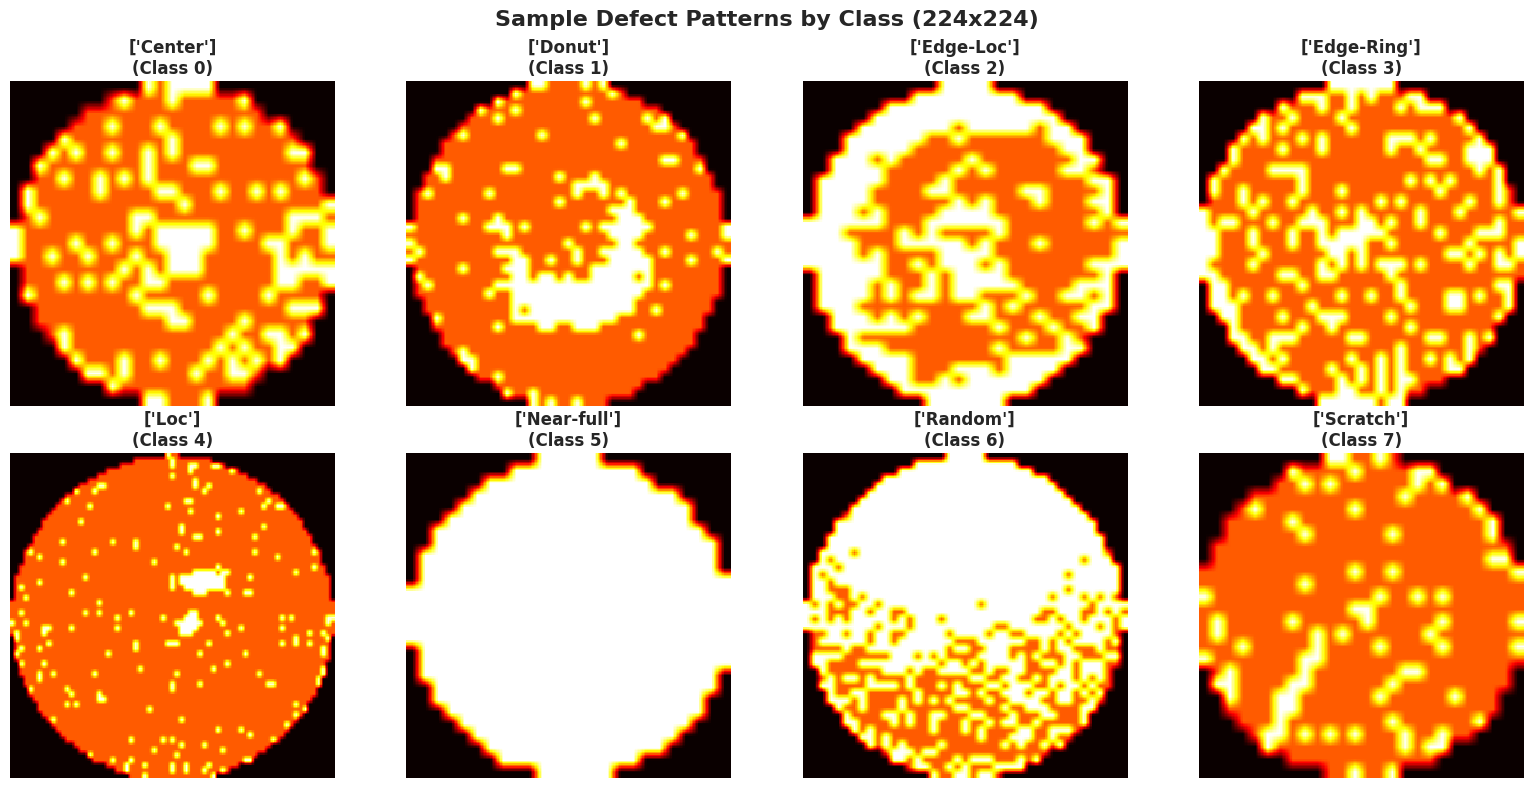

In [8]:
def preprocess_single(wafer_map):
    arr = np.array(wafer_map, dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    return arr_resized

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(le.classes_):
    class_idx = np.where(y_train == i)[0][0]
    sample = preprocess_single(X_train[class_idx])
    
    axes[i].imshow(sample, cmap='hot', interpolation='nearest')
    axes[i].set_title(f'{class_name}\n(Class {i})', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Defect Patterns by Class (224x224)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

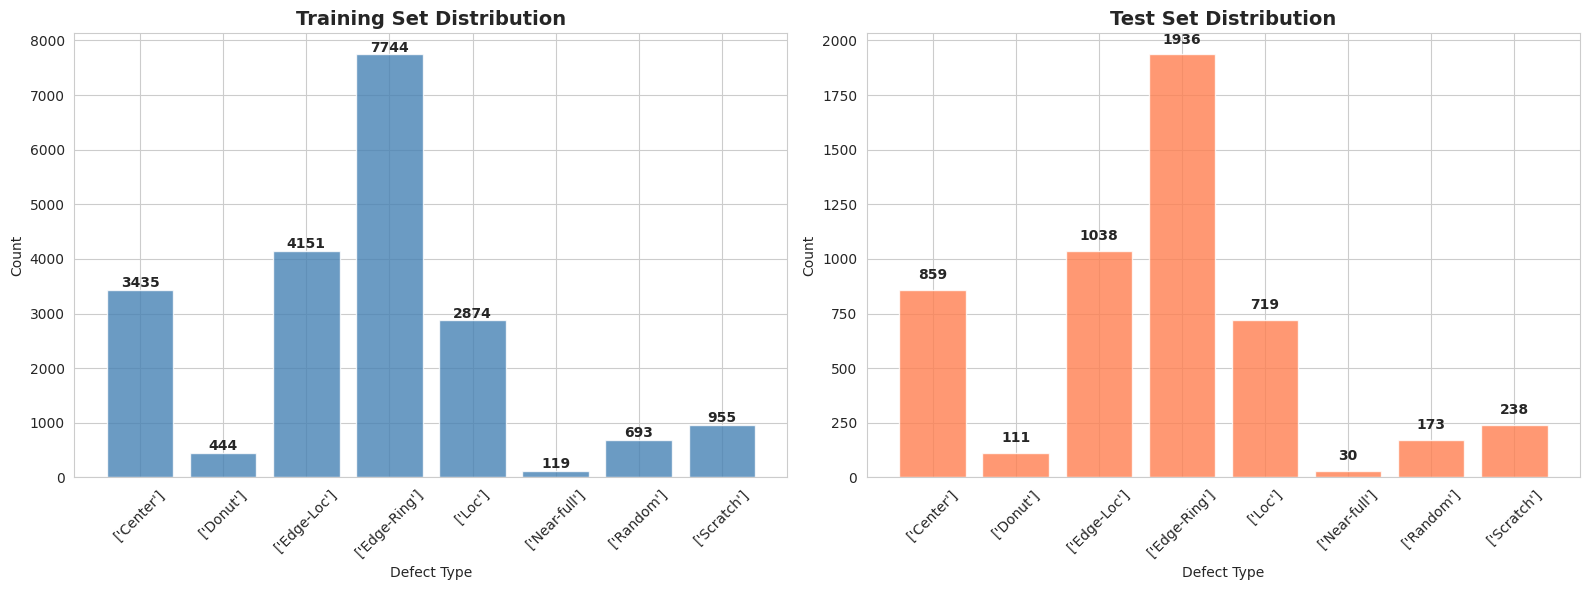

Class distribution analyzed!

Class Balance Ratio (Train): 0.015
Class Balance Ratio (Test): 0.015


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

train_counts = pd.Series(y_train).value_counts().sort_index()
train_labels = [le.classes_[i] for i in train_counts.index]
ax1.bar(train_labels, train_counts.values, color='steelblue', alpha=0.8)
ax1.set_title('Training Set Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Defect Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(train_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')

test_counts = pd.Series(y_test).value_counts().sort_index()
test_labels = [le.classes_[i] for i in test_counts.index]
ax2.bar(test_labels, test_counts.values, color='coral', alpha=0.8)
ax2.set_title('Test Set Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Defect Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(test_counts.values):
    ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Class distribution analyzed!")
print(f"\nClass Balance Ratio (Train): {train_counts.min() / train_counts.max():.3f}")
print(f"Class Balance Ratio (Test): {test_counts.min() / test_counts.max():.3f}")

PCA explained variance: 61.36%


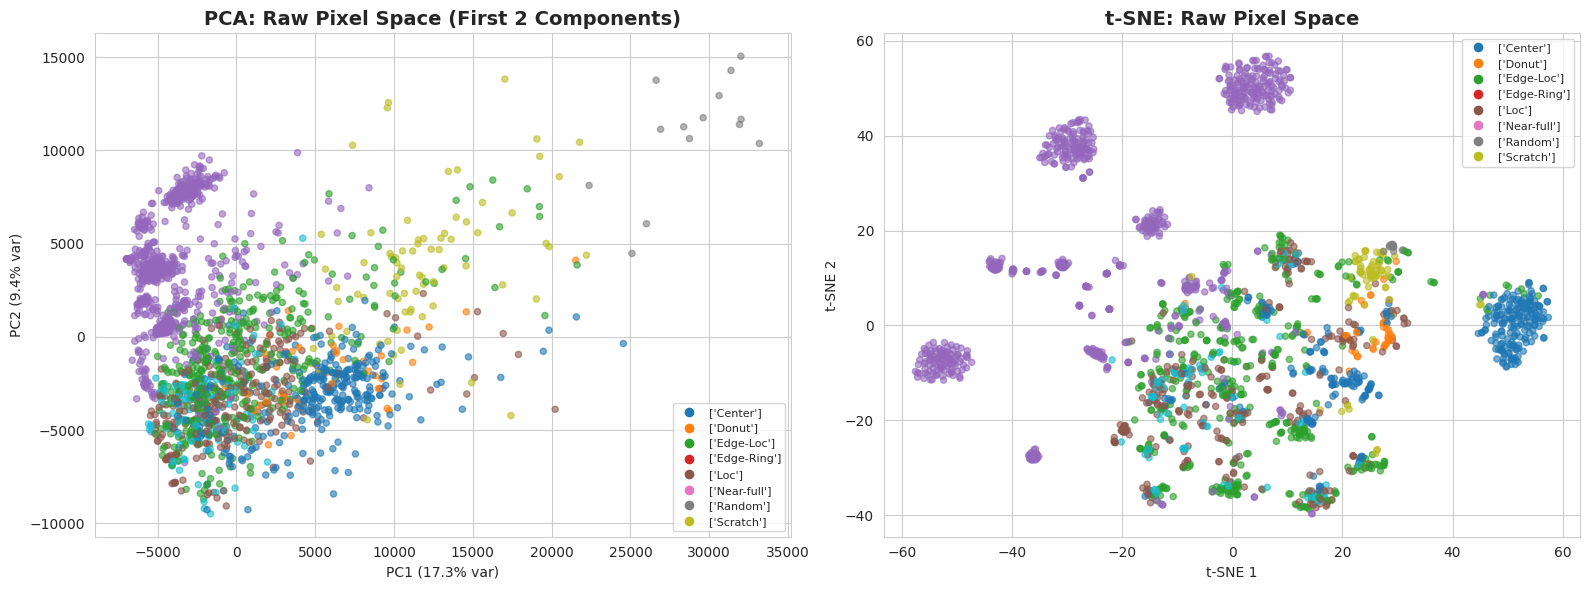

In [10]:
X_subset_flat = []
for i in range(min(2000, len(X_train))):
    arr = np.array(X_train[i], dtype=np.float32)
    if arr.max() > 0:
        arr = arr / arr.max()
    arr_resized = cv2.resize(arr, (224, 224))
    arr_rgb = np.stack([arr_resized] * 3, axis=-1)
    arr_rgb = preprocess_input(arr_rgb * 255.0)

    X_subset_flat.append(arr_rgb.flatten())

X_subset_flat = np.array(X_subset_flat)
y_train_subset = y_train[:len(X_subset_flat)]

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_subset_flat)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax1.set_title('PCA: Raw Pixel Space (First 2 Components)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')

legend_elements_1 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax1.legend(handles=legend_elements_1, loc='best', fontsize=8)

scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                       c=y_train_subset, cmap='tab10', 
                       alpha=0.6, s=20)
ax2.set_title('t-SNE: Raw Pixel Space', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

legend_elements_2 = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=plt.cm.tab10(i/num_classes), 
                                markersize=8, label=le.classes_[i]) 
                     for i in range(num_classes)]
ax2.legend(handles=legend_elements_2, loc='best', fontsize=8)

plt.tight_layout()
plt.show()

**section 3 hai**

In [11]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

custom_cnn = build_custom_cnn(num_classes=num_classes)
custom_cnn.summary()

I0000 00:00:1766837855.327936      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766837855.328685      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,136 (5.51 MB)

 Trainable params: 1,440,680 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [12]:
def build_resnet152(input_shape=(224, 224, 3), num_classes=8):
    base_model = ResNet152(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

resnet_model = build_resnet152(num_classes=num_classes)
print(f"ResNet152 built")
print(f"Total params: {resnet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in resnet_model.trainable_weights]):,}")

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
ResNet152 built
Total params: 59,426,184
Trainable params: 59,273,736


In [13]:
def build_inceptionv3(input_shape=(224, 224, 3), num_classes=8):
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
inception_model = build_inceptionv3(num_classes=num_classes)
print(f"InceptionV3 built!")
print(f"Total params: {inception_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in inception_model.trainable_weights]):,}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
InceptionV3 built!
Total params: 22,858,024
Trainable params: 22,822,568


In [14]:
def build_densenet121(input_shape=(224, 224, 3), num_classes=8):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

densenet_model = build_densenet121(num_classes=num_classes)
print(f"DenseNet121 built")
print(f"Total params: {densenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in densenet_model.trainable_weights]):,}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 built
Total params: 7,568,456
Trainable params: 7,483,784


In [15]:
def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=8):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

mobilenet_model = build_mobilenetv2(num_classes=num_classes)
print(f"MobileNetV2 built")
print(f"Total params: {mobilenet_model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in mobilenet_model.trainable_weights]):,}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 built
Total params: 2,920,008
Trainable params: 2,187,400




**imp block ---- rishi look into this --- this is like the training universal block, have included callbacks**

In [16]:
def train_model_gen(model, model_name, train_gen, test_gen, epochs=15):
    print(f"Training {model_name}")
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]
    
    start_time = time.time()
    
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    print(f"\n{model_name} Complete")
    print(f"Time: {train_time/60:.2f} minutes")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    
    return history, train_time, test_acc

In [17]:
def clear_session_memory():
    keras.backend.clear_session()
    import gc
    gc.collect()
    print("Memory cleared")

print("Memory management ready!")

Memory management ready!


Training Custom CNN
Epoch 1/15


I0000 00:00:1766837875.084435     122 service.cc:148] XLA service 0x7b679000ce90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766837875.085455     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766837875.085486     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766837876.080656     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1276 ━━━━━━━━━━━━━━━━━━━━ 7:18:59 21s/step - accuracy: 0.1875 - loss: 3.2057

I0000 00:00:1766837889.193332     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1276/1276 ━━━━━━━━━━━━━━━━━━━━ 151s 102ms/step - accuracy: 0.5676 - loss: 1.3559 - val_accuracy: 0.6795 - val_loss: 0.7762 - learning_rate: 0.0010
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 118s 92ms/step - accuracy: 0.7141 - loss: 0.7443 - val_accuracy: 0.6616 - val_loss: 0.9977 - learning_rate: 0.0010
Epoch 3/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 116s 91ms/step - accuracy: 0.7591 - loss: 0.6371 - val_accuracy: 0.7404 - val_loss: 0.7110 - learning_rate: 0.0010
Epoch 4/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 116s 91ms/step - accuracy: 0.8079 - loss: 0.5132 - val_accuracy: 0.5472 - val_loss: 1.8165 - learning_rate: 0.0010
Epoch 5/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 116s 91ms/step - accuracy: 0.8280 - loss: 0.4610 - val_accuracy: 0.8060 - val_loss: 0.5822 - learning_rate: 0.0010
Epoch 6/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 117s 92ms/step - accuracy: 0.8487 - loss: 0.4085 - val_accuracy: 0.8507 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 7/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 116s 91ms/step - accuracy:

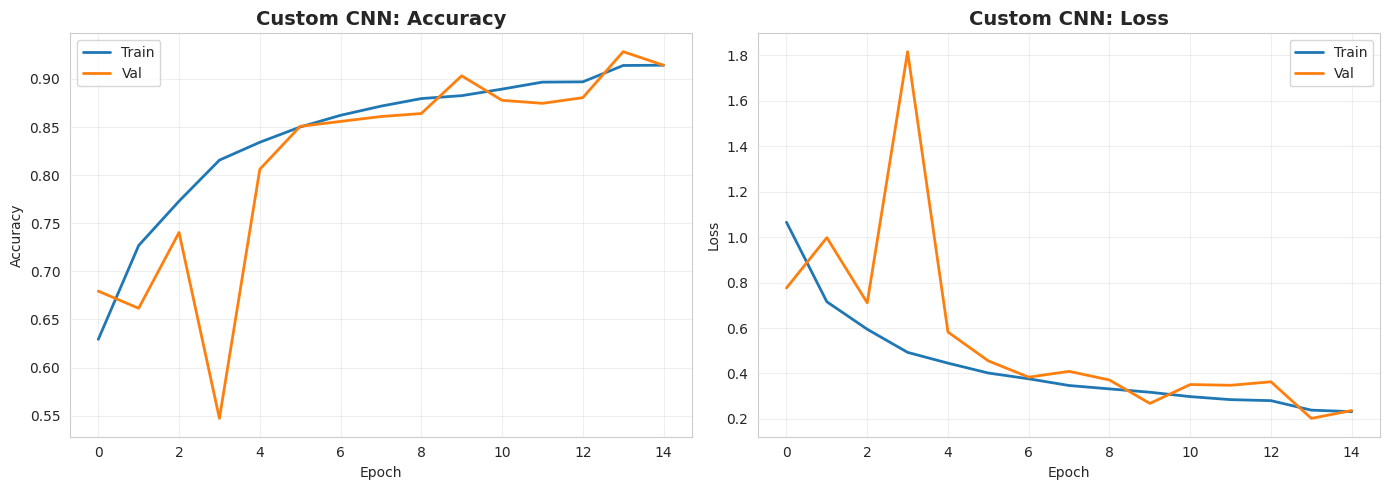

Custom CNN training complete


In [18]:
keras.backend.clear_session()
import gc
gc.collect()

model_custom = build_custom_cnn(num_classes=num_classes)

history_custom, time_custom, acc_custom = train_model_gen(
    model=model_custom,
    model_name="Custom CNN",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_custom.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history_custom.history['val_accuracy'], label='Val', linewidth=2)
ax1.set_title('Custom CNN: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_custom.history['loss'], label='Train', linewidth=2)
ax2.plot(history_custom.history['val_loss'], label='Val', linewidth=2)
ax2.set_title('Custom CNN: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Custom CNN training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 252s 176ms/step - accuracy: 0.6964 - loss: 0.8908 - val_accuracy: 0.8105 - val_loss: 0.4951
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 204s 160ms/step - accuracy: 0.7984 - loss: 0.5356 - val_accuracy: 0.8062 - val_loss: 0.5147
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 207s 163ms/step - accuracy: 0.7983 - loss: 0.5203 - val_accuracy: 0.8397 - val_loss: 0.4124
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 207s 162ms/step - accuracy: 0.8178 - loss: 0.4785 - val_accuracy: 0.8417 - val_loss: 0.4063
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 208s 163ms/step - accuracy: 0.8213 - loss: 0.4716 - val_accuracy: 0.8384 - val_loss: 0.4219
Training ResNet152
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 846s 550ms/step - accuracy: 0.7364 - loss: 0.7886 - val_accuracy: 0.8938 - val_loss: 0.2998 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 640s 502ms/step - accuracy: 0.8849 - loss: 0.3276 - val_accuracy: 0.9165 - val_loss: 0.2397 - learning_rate: 1.0

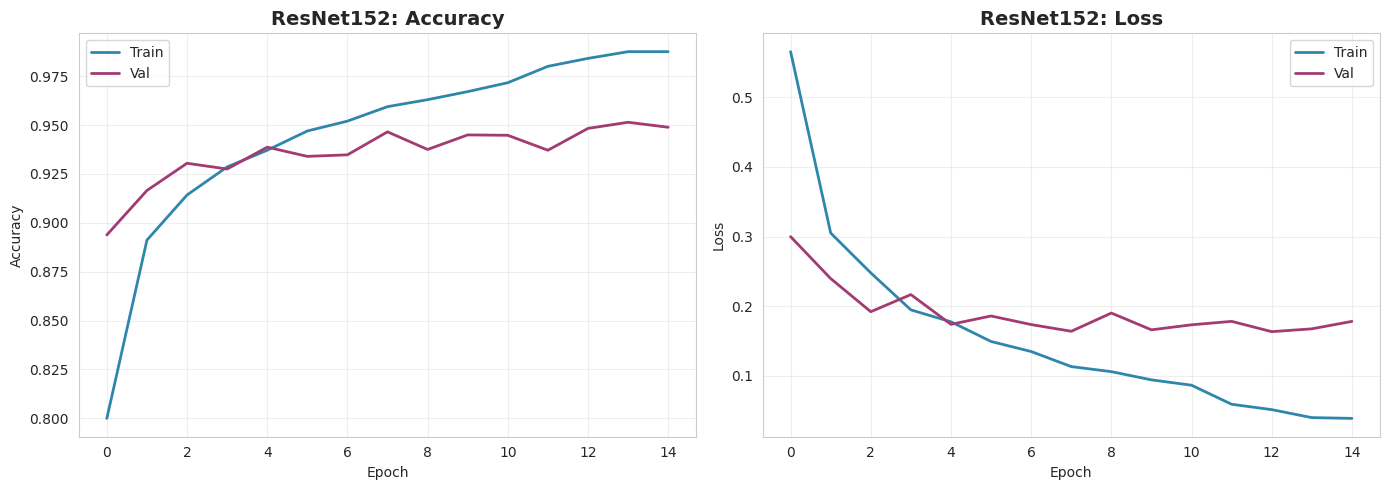

ResNet152 training complete


In [19]:
keras.backend.clear_session()
import gc
gc.collect()

model_resnet = build_resnet152(num_classes=num_classes)

model_resnet.layers[0].trainable = False
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.fit(train_gen, validation_data=test_gen, epochs=5)

model_resnet.layers[0].trainable = True
model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet, time_resnet, acc_resnet = train_model_gen(
    model=model_resnet,
    model_name="ResNet152",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"Final Test Accuracy: {acc_resnet*100:.2f}%")
print(f"Training Time: {time_resnet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_resnet.history['accuracy'], label='Train', linewidth=2, color='#2E86AB')
ax1.plot(history_resnet.history['val_accuracy'], label='Val', linewidth=2, color='#A23B72')
ax1.set_title('ResNet152: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_resnet.history['loss'], label='Train', linewidth=2, color='#2E86AB')
ax2.plot(history_resnet.history['val_loss'], label='Val', linewidth=2, color='#A23B72')
ax2.set_title('ResNet152: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ResNet152 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 92s 60ms/step - accuracy: 0.6279 - loss: 1.1269 - val_accuracy: 0.7181 - val_loss: 0.7677
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.7168 - loss: 0.7460 - val_accuracy: 0.7467 - val_loss: 0.6554
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.7320 - loss: 0.7258 - val_accuracy: 0.7392 - val_loss: 0.6751
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.7298 - loss: 0.7031 - val_accuracy: 0.7371 - val_loss: 0.6826
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 61s 48ms/step - accuracy: 0.7343 - loss: 0.7071 - val_accuracy: 0.7132 - val_loss: 0.8044
Training InceptionV3
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 295s 180ms/step - accuracy: 0.5805 - loss: 1.2733 - val_accuracy: 0.7482 - val_loss: 0.6506 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 192s 151ms/step - accuracy: 0.7420 - loss: 0.6724 - val_accuracy: 0.8141 - val_loss: 0.4767 - learning_rate: 1.0000e-05


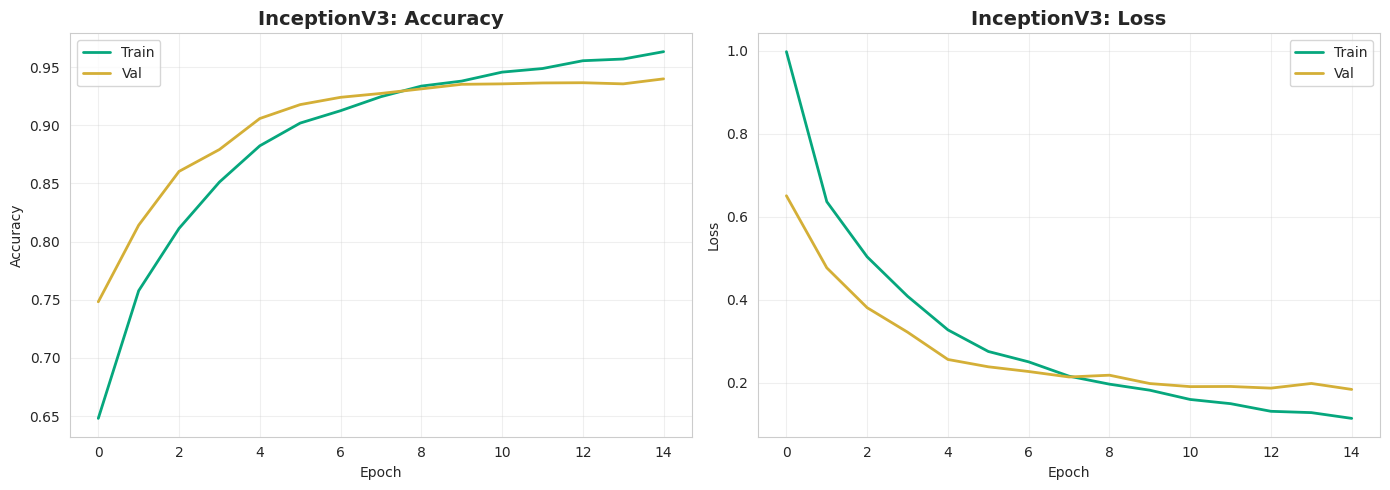

InceptionV3 training complete


In [20]:
keras.backend.clear_session()
import gc
gc.collect()

model_inception = build_inceptionv3(num_classes=num_classes)

model_inception.layers[0].trainable = False
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_inception.fit(train_gen, validation_data=test_gen, epochs=5)

model_inception.layers[0].trainable = True
model_inception.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_inception, time_inception, acc_inception = train_model_gen(
    model=model_inception,
    model_name="InceptionV3",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"InceptionV3 Training Summary")
print(f"Final Test Accuracy: {acc_inception*100:.2f}%")
print(f"Training Time: {time_inception/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_inception.history['accuracy'], label='Train', linewidth=2, color='#06A77D')
ax1.plot(history_inception.history['val_accuracy'], label='Val', linewidth=2, color='#D4AF37')
ax1.set_title('InceptionV3: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_inception.history['loss'], label='Train', linewidth=2, color='#06A77D')
ax2.plot(history_inception.history['val_loss'], label='Val', linewidth=2, color='#D4AF37')
ax2.set_title('InceptionV3: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("InceptionV3 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 117s 72ms/step - accuracy: 0.6531 - loss: 0.9762 - val_accuracy: 0.6609 - val_loss: 0.8576
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7215 - loss: 0.7139 - val_accuracy: 0.6640 - val_loss: 0.8269
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 72s 56ms/step - accuracy: 0.7375 - loss: 0.6891 - val_accuracy: 0.6336 - val_loss: 1.0115
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 73s 57ms/step - accuracy: 0.7446 - loss: 0.6651 - val_accuracy: 0.7482 - val_loss: 0.6498
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 72s 56ms/step - accuracy: 0.7472 - loss: 0.6555 - val_accuracy: 0.6828 - val_loss: 0.8721
Training DenseNet121
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 459s 246ms/step - accuracy: 0.5838 - loss: 1.5646 - val_accuracy: 0.7735 - val_loss: 0.6234 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 226s 177ms/step - accuracy: 0.7597 - loss: 0.6674 - val_accuracy: 0.8203 - val_loss: 0.4811 - learning_rate: 1.0000e-05

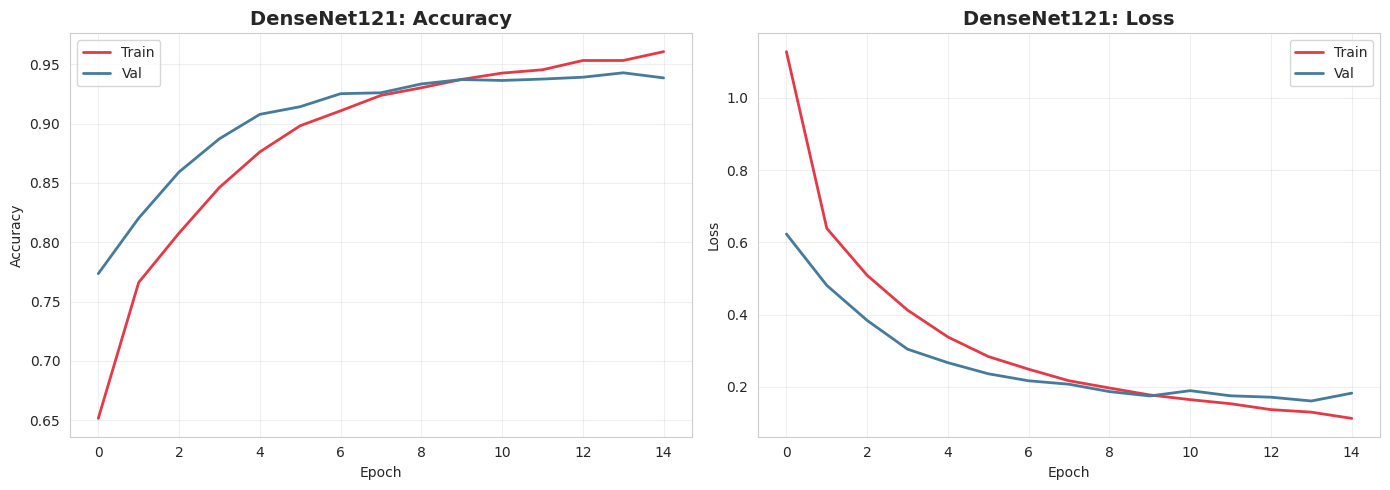

DenseNet121 training complete


In [21]:
keras.backend.clear_session()
import gc
gc.collect()

model_densenet = build_densenet121(num_classes=num_classes)

model_densenet.layers[0].trainable = False
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_densenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_densenet.layers[0].trainable = True
model_densenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_densenet, time_densenet, acc_densenet = train_model_gen(
    model=model_densenet,
    model_name="DenseNet121",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)

print(f"DenseNet121 Training Summary")
print(f"Final Test Accuracy: {acc_densenet*100:.2f}%")
print(f"Training Time: {time_densenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_densenet.history['accuracy'], label='Train', linewidth=2, color='#E63946')
ax1.plot(history_densenet.history['val_accuracy'], label='Val', linewidth=2, color='#457B9D')
ax1.set_title('DenseNet121: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_densenet.history['loss'], label='Train', linewidth=2, color='#E63946')
ax2.plot(history_densenet.history['val_loss'], label='Val', linewidth=2, color='#457B9D')
ax2.set_title('DenseNet121: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("DenseNet121 training complete")

Epoch 1/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.6326 - loss: 1.0264 - val_accuracy: 0.6799 - val_loss: 0.7959
Epoch 2/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.7156 - loss: 0.7344 - val_accuracy: 0.7429 - val_loss: 0.6664
Epoch 3/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.7180 - loss: 0.7239 - val_accuracy: 0.7455 - val_loss: 0.6427
Epoch 4/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.7426 - loss: 0.6639 - val_accuracy: 0.7112 - val_loss: 0.6893
Epoch 5/5
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7377 - loss: 0.6770 - val_accuracy: 0.7404 - val_loss: 0.6487
Training MobileNetV2
Epoch 1/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 151s 84ms/step - accuracy: 0.5716 - loss: 1.4086 - val_accuracy: 0.6164 - val_loss: 1.2672 - learning_rate: 1.0000e-05
Epoch 2/15
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.7181 - loss: 0.7439 - val_accuracy: 0.7569 - val_loss: 0.6766 - learning_rate: 1.0000e-05
Epo

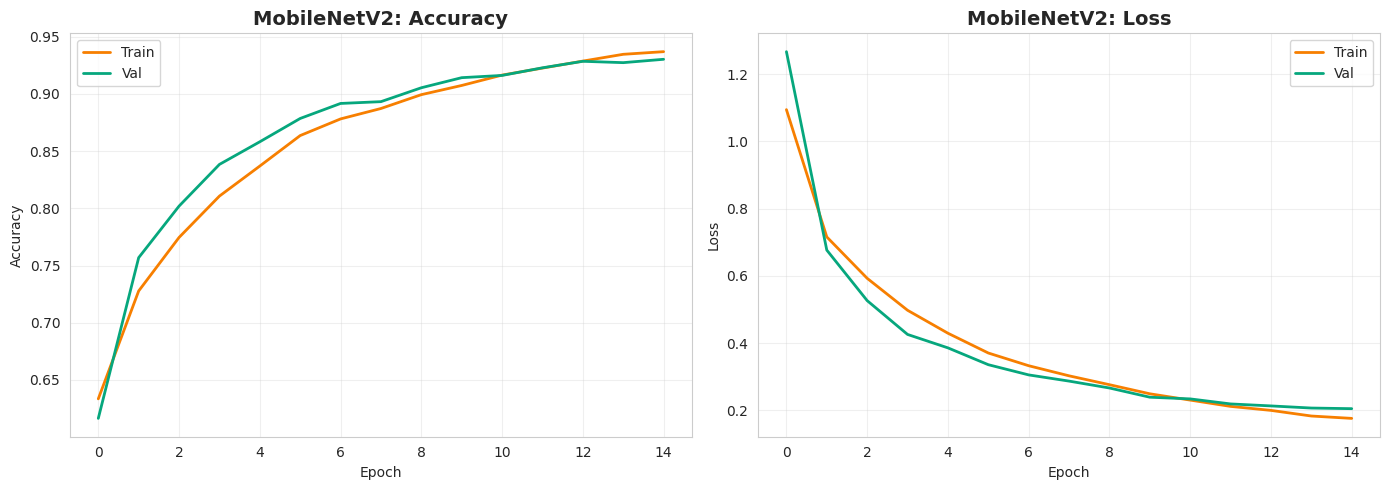

MobileNetV2 training complete


In [22]:
keras.backend.clear_session()
import gc
gc.collect()

model_mobilenet = build_mobilenetv2(num_classes=num_classes)

model_mobilenet.layers[0].trainable = False
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenet.fit(train_gen, validation_data=test_gen, epochs=5)

model_mobilenet.layers[0].trainable = True
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet, time_mobilenet, acc_mobilenet = train_model_gen(
    model=model_mobilenet,
    model_name="MobileNetV2",
    train_gen=train_gen,
    test_gen=test_gen,
    epochs=15
)


print(f"MobileNetV2 Training Summary")
print(f"Final Test Accuracy: {acc_mobilenet*100:.2f}%")
print(f"Training Time: {time_mobilenet/60:.2f} minutes")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_mobilenet.history['accuracy'], label='Train', linewidth=2, color='#F77F00')
ax1.plot(history_mobilenet.history['val_accuracy'], label='Val', linewidth=2, color='#06A77D')
ax1.set_title('MobileNetV2: Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history_mobilenet.history['loss'], label='Train', linewidth=2, color='#F77F00')
ax2.plot(history_mobilenet.history['val_loss'], label='Val', linewidth=2, color='#06A77D')
ax2.set_title('MobileNetV2: Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("MobileNetV2 training complete")


ALL MODELS TRAINED - QUICK COMPARISON
      Model  Test Accuracy (%)  Training Time (min)
  ResNet152          95.003921           162.907139
DenseNet121          94.514108            60.328398
InceptionV3          94.278997            49.560227
MobileNetV2          92.868340            21.981715
 Custom CNN          92.672414            29.661745


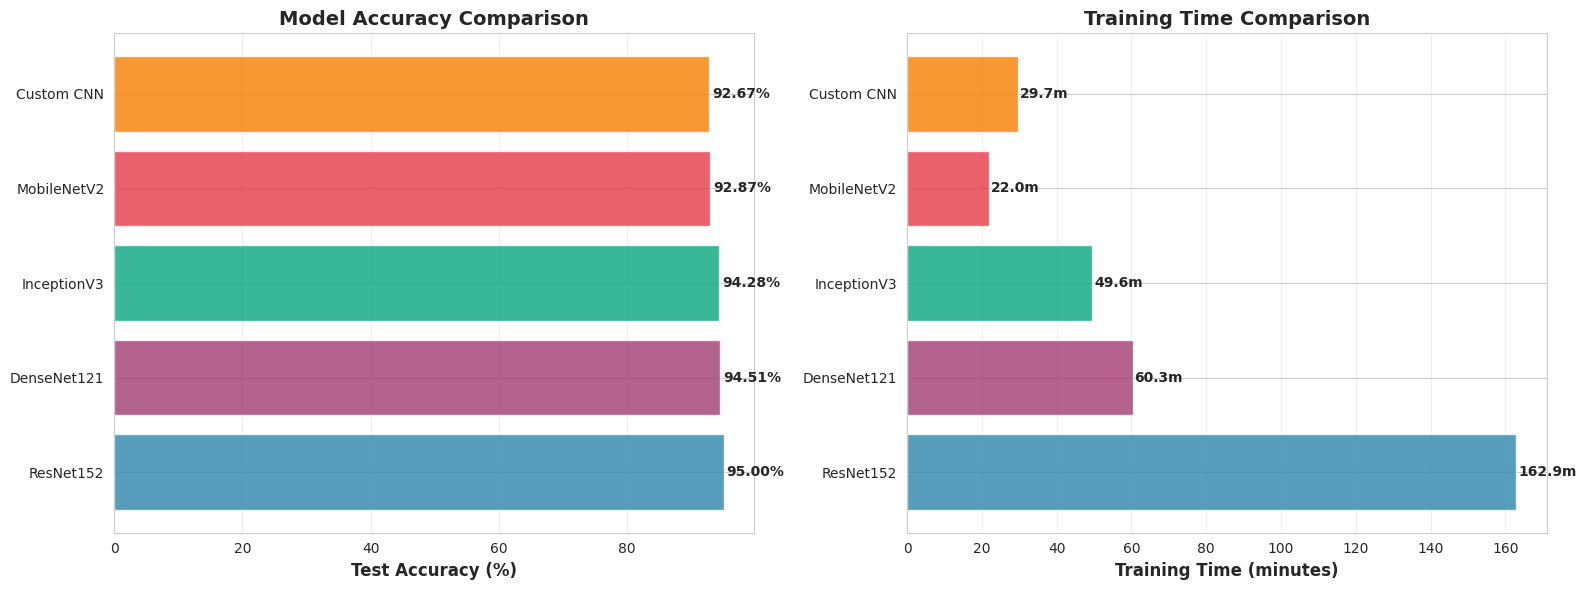

In [23]:
results_summary = {
    'Model': ['Custom CNN', 'ResNet152', 'InceptionV3', 'DenseNet121', 'MobileNetV2'],
    'Test Accuracy (%)': [
        acc_custom * 100,
        acc_resnet * 100,
        acc_inception * 100,
        acc_densenet * 100,
        acc_mobilenet * 100
    ],
    'Training Time (min)': [
        time_custom / 60,
        time_resnet / 60,
        time_inception / 60,
        time_densenet / 60,
        time_mobilenet / 60
    ]
}

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values('Test Accuracy (%)', ascending=False)

print("\n" + "="*70)
print("ALL MODELS TRAINED - QUICK COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2E86AB', '#A23B72', '#06A77D', '#E63946', '#F77F00']
ax1.barh(results_df['Model'], results_df['Test Accuracy (%)'], color=colors, alpha=0.8)
ax1.set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Test Accuracy (%)']):
    ax1.text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')

ax2.barh(results_df['Model'], results_df['Training Time (min)'], color=colors, alpha=0.8)
ax2.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['Training Time (min)']):
    ax2.text(v + 0.5, i, f'{v:.1f}m', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Custom CNN - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
               precision    recall  f1-score   support

   ['Center']       0.90      0.97      0.93       859
    ['Donut']       0.77      0.79      0.78       111
 ['Edge-Loc']       0.94      0.87      0.91      1038
['Edge-Ring']       0.98      0.98      0.98      1936
      ['Loc']       0.82      0.84      0.83       719
['Near-full']       0.93      0.83      0.88        30
   ['Random']       0.89      0.92      0.91       173
  ['Scratch']       0.92      0.86      0.89       238

     accuracy                           0.92      5104
    macro avg       0.89      0.88      0.89      5104
 weighted avg       0.93      0.92      0.92      5104



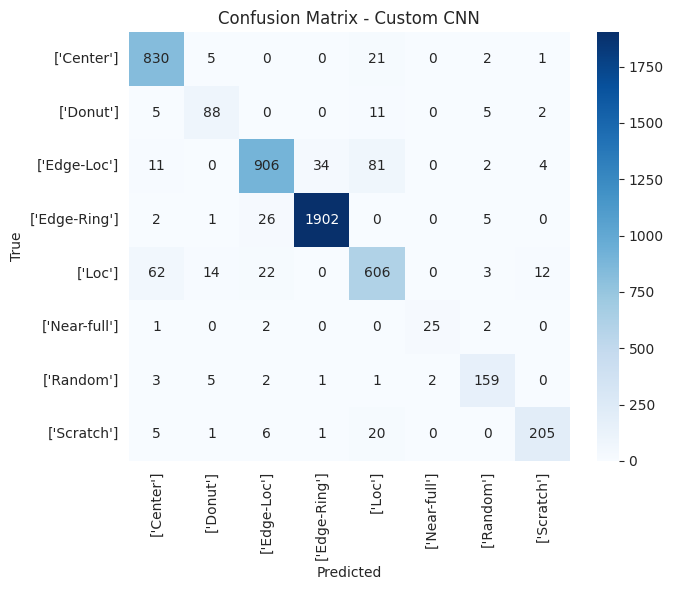

ResNet152 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 132ms/step
               precision    recall  f1-score   support

   ['Center']       0.97      0.98      0.97       859
    ['Donut']       0.90      0.83      0.86       111
 ['Edge-Loc']       0.92      0.94      0.93      1038
['Edge-Ring']       0.99      0.99      0.99      1936
      ['Loc']       0.89      0.86      0.88       719
['Near-full']       0.88      0.93      0.90        30
   ['Random']       0.96      0.88      0.92       173
  ['Scratch']       0.91      0.89      0.90       238

     accuracy                           0.95      5104
    macro avg       0.93      0.91      0.92      5104
 weighted avg       0.95      0.95      0.95      5104



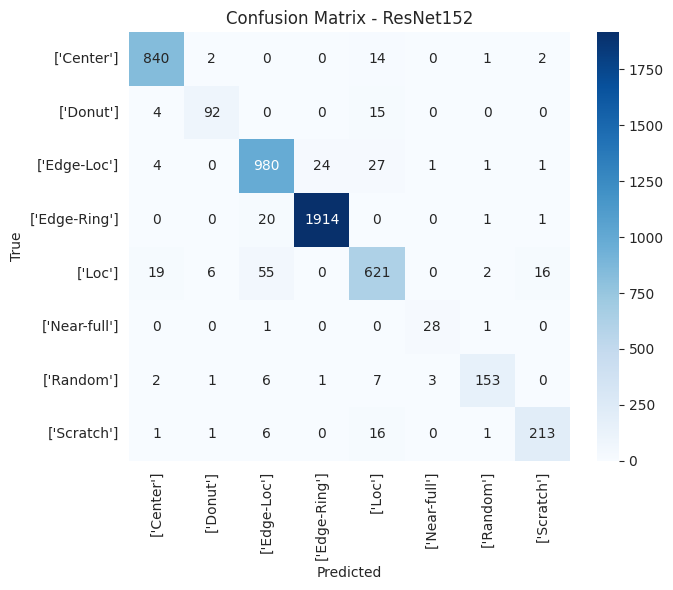

InceptionV3 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
               precision    recall  f1-score   support

   ['Center']       0.96      0.97      0.96       859
    ['Donut']       0.91      0.87      0.89       111
 ['Edge-Loc']       0.92      0.92      0.92      1038
['Edge-Ring']       0.98      0.99      0.98      1936
      ['Loc']       0.88      0.89      0.88       719
['Near-full']       0.81      1.00      0.90        30
   ['Random']       0.91      0.88      0.90       173
  ['Scratch']       0.91      0.90      0.91       238

     accuracy                           0.94      5104
    macro avg       0.91      0.93      0.92      5104
 weighted avg       0.94      0.94      0.94      5104



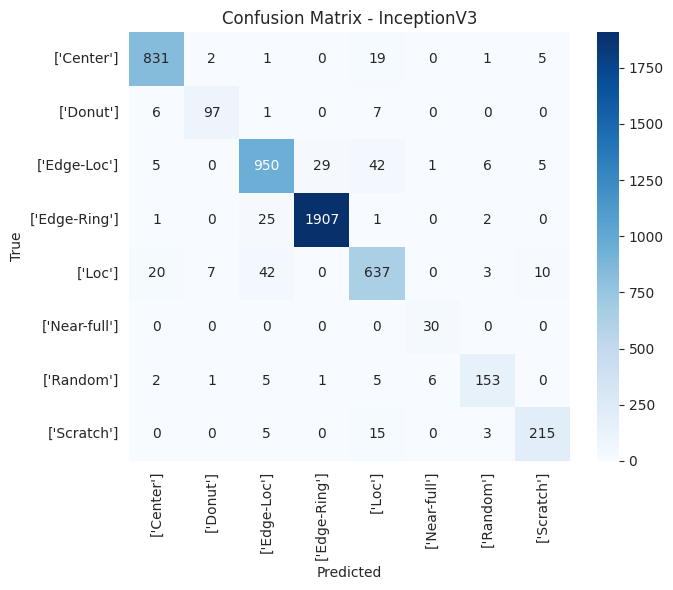

DenseNet121 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step
               precision    recall  f1-score   support

   ['Center']       0.96      0.98      0.97       859
    ['Donut']       0.91      0.87      0.89       111
 ['Edge-Loc']       0.91      0.94      0.92      1038
['Edge-Ring']       0.98      0.99      0.98      1936
      ['Loc']       0.91      0.84      0.87       719
['Near-full']       0.88      0.93      0.90        30
   ['Random']       0.97      0.91      0.94       173
  ['Scratch']       0.90      0.90      0.90       238

     accuracy                           0.95      5104
    macro avg       0.93      0.92      0.92      5104
 weighted avg       0.95      0.95      0.95      5104



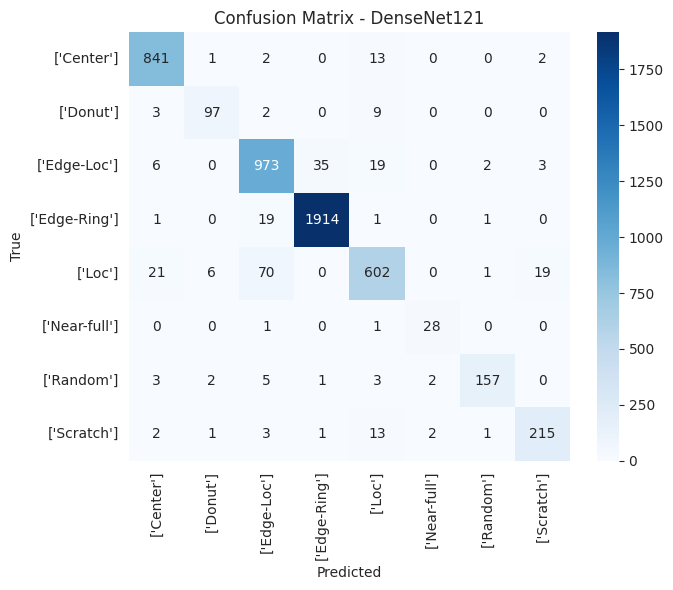

MobileNetV2 - Classification Report
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
               precision    recall  f1-score   support

   ['Center']       0.95      0.97      0.96       859
    ['Donut']       0.85      0.79      0.82       111
 ['Edge-Loc']       0.87      0.92      0.90      1038
['Edge-Ring']       0.98      0.99      0.98      1936
      ['Loc']       0.88      0.80      0.84       719
['Near-full']       0.86      0.83      0.85        30
   ['Random']       0.97      0.88      0.92       173
  ['Scratch']       0.87      0.89      0.88       238

     accuracy                           0.93      5104
    macro avg       0.91      0.89      0.89      5104
 weighted avg       0.93      0.93      0.93      5104



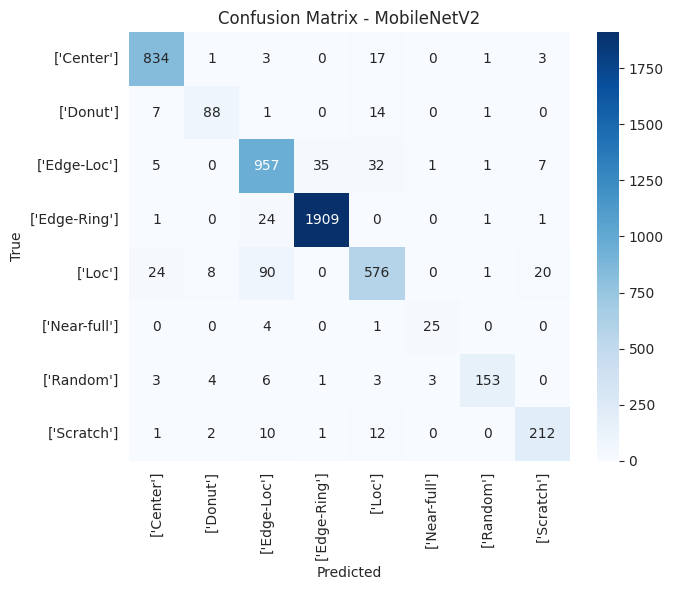

In [24]:
models_dict = {
    "Custom CNN": model_custom,
    "ResNet152": model_resnet,
    "InceptionV3": model_inception,
    "DenseNet121": model_densenet,
    "MobileNetV2": model_mobilenet
}

def evaluate_model(model, name, test_gen):
    print(f"{name} - Classification Report")
    y_true = test_gen.labels[:len(test_gen.indices)]

    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred


results_preds = {}

for name, model in models_dict.items():
    y_t, y_p = evaluate_model(model, name, test_gen)
    results_preds[name] = (y_t, y_p)

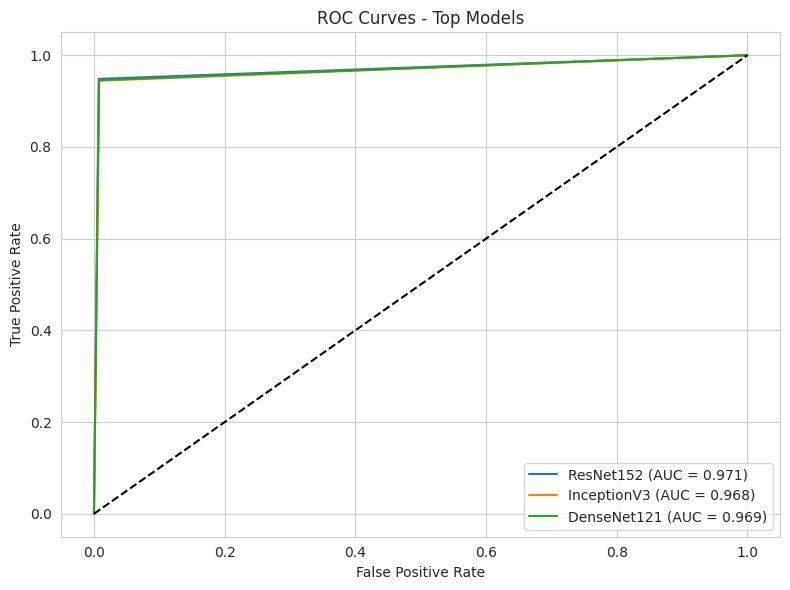

In [25]:
plt.figure(figsize=(8,6))

for name in ["ResNet152", "InceptionV3", "DenseNet121"]:
    y_true, y_pred = results_preds[name]
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Top Models")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model_final(model, name, test_gen):
    print(f"\n{'='*60}")
    print(f"{name} - Final Evaluation")
    print(f"{'='*60}")

    y_true, y_pred, y_prob = [], [], []

    for X_batch, y_batch in test_gen:
        probs = model.predict(X_batch, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(y_batch)
        y_pred.extend(preds)
        y_prob.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(classification_report(
        y_true, y_pred,
        target_names=le.classes_,
        digits=4
    ))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_prob, macro_f1, weighted_f1

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate_model_final(model, name, test_gen):
    print(f"\n{'='*60}")
    print(f"{name} - Final Evaluation")
    print(f"{'='*60}")

    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)

    y_true = test_gen.labels[:len(y_pred)]

    print(classification_report(
        y_true, y_pred,
        target_names=le.classes_,
        digits=4
    ))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return y_true, y_pred, y_prob, macro_f1, weighted_f1


Custom CNN - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
               precision    recall  f1-score   support

   ['Center']     0.9040    0.9651    0.9336       859
    ['Donut']     0.7632    0.7838    0.7733       111
 ['Edge-Loc']     0.9407    0.8863    0.9127      1038
['Edge-Ring']     0.9824    0.9830    0.9827      1936
      ['Loc']     0.8262    0.8331    0.8296       719
['Near-full']     0.9259    0.8333    0.8772        30
   ['Random']     0.8914    0.9017    0.8966       173
  ['Scratch']     0.9134    0.8866    0.8998       238

     accuracy                         0.9267      5104
    macro avg     0.8934    0.8841    0.8882      5104
 weighted avg     0.9273    0.9267    0.9267      5104

Macro F1:    0.8882
Weighted F1: 0.9267


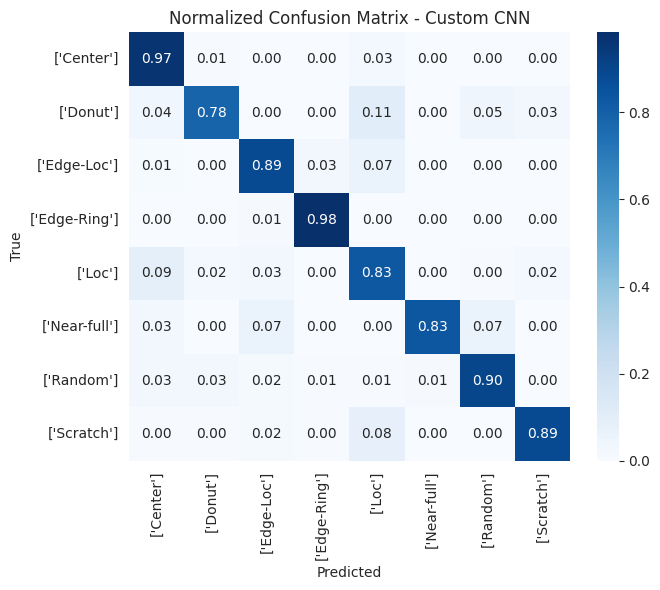


ResNet152 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step
               precision    recall  f1-score   support

   ['Center']     0.9721    0.9732    0.9727       859
    ['Donut']     0.9126    0.8468    0.8785       111
 ['Edge-Loc']     0.9064    0.9422    0.9239      1038
['Edge-Ring']     0.9855    0.9861    0.9858      1936
      ['Loc']     0.8895    0.8734    0.8814       719
['Near-full']     0.8485    0.9333    0.8889        30
   ['Random']     0.9623    0.8844    0.9217       173
  ['Scratch']     0.9295    0.8866    0.9075       238

     accuracy                         0.9477      5104
    macro avg     0.9258    0.9158    0.9201      5104
 weighted avg     0.9479    0.9477    0.9476      5104

Macro F1:    0.9201
Weighted F1: 0.9476


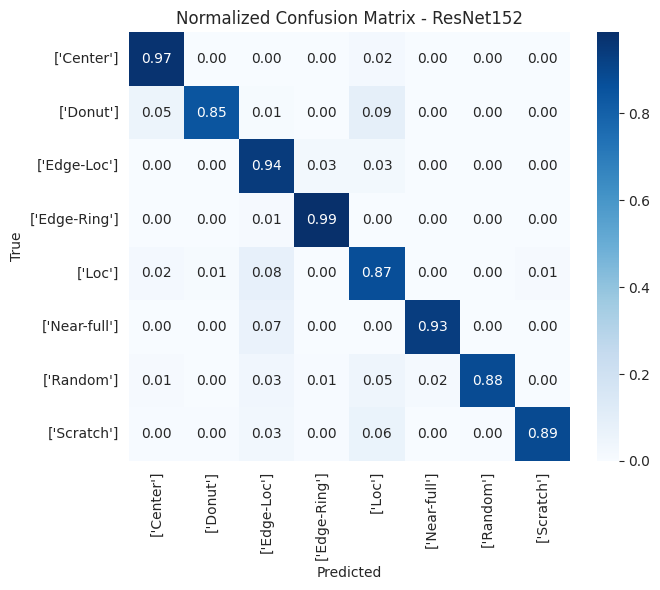


InceptionV3 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
               precision    recall  f1-score   support

   ['Center']     0.9621    0.9744    0.9682       859
    ['Donut']     0.8909    0.8829    0.8869       111
 ['Edge-Loc']     0.9235    0.9075    0.9155      1038
['Edge-Ring']     0.9871    0.9845    0.9858      1936
      ['Loc']     0.8622    0.8790    0.8705       719
['Near-full']     0.8108    1.0000    0.8955        30
   ['Random']     0.9064    0.8960    0.9012       173
  ['Scratch']     0.9181    0.8950    0.9064       238

     accuracy                         0.9430      5104
    macro avg     0.9076    0.9274    0.9162      5104
 weighted avg     0.9433    0.9430    0.9430      5104

Macro F1:    0.9162
Weighted F1: 0.9430


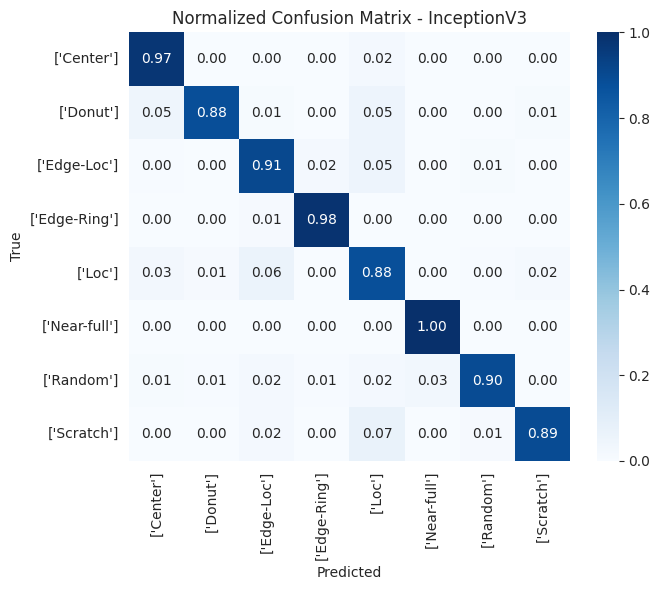


DenseNet121 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step
               precision    recall  f1-score   support

   ['Center']     0.9622    0.9790    0.9706       859
    ['Donut']     0.8868    0.8468    0.8664       111
 ['Edge-Loc']     0.9079    0.9306    0.9191      1038
['Edge-Ring']     0.9790    0.9886    0.9838      1936
      ['Loc']     0.9036    0.8470    0.8744       719
['Near-full']     0.9355    0.9667    0.9508        30
   ['Random']     0.9755    0.9191    0.9464       173
  ['Scratch']     0.9156    0.9118    0.9137       238

     accuracy                         0.9461      5104
    macro avg     0.9333    0.9237    0.9281      5104
 weighted avg     0.9458    0.9461    0.9457      5104

Macro F1:    0.9281
Weighted F1: 0.9457


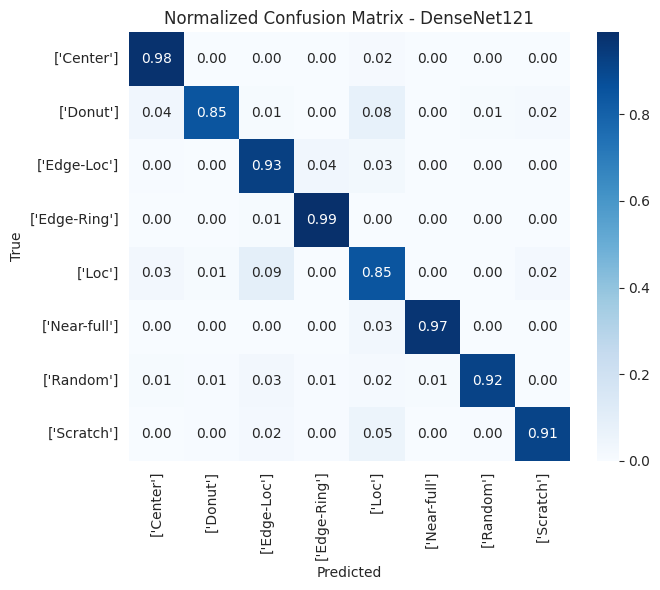


MobileNetV2 - Final Evaluation
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
               precision    recall  f1-score   support

   ['Center']     0.9460    0.9593    0.9526       859
    ['Donut']     0.8426    0.8198    0.8311       111
 ['Edge-Loc']     0.8825    0.9191    0.9004      1038
['Edge-Ring']     0.9775    0.9876    0.9825      1936
      ['Loc']     0.8654    0.7872    0.8245       719
['Near-full']     0.7812    0.8333    0.8065        30
   ['Random']     0.9490    0.8613    0.9030       173
  ['Scratch']     0.8571    0.8824    0.8696       238

     accuracy                         0.9269      5104
    macro avg     0.8877    0.8812    0.8838      5104
 weighted avg     0.9264    0.9269    0.9262      5104

Macro F1:    0.8838
Weighted F1: 0.9262


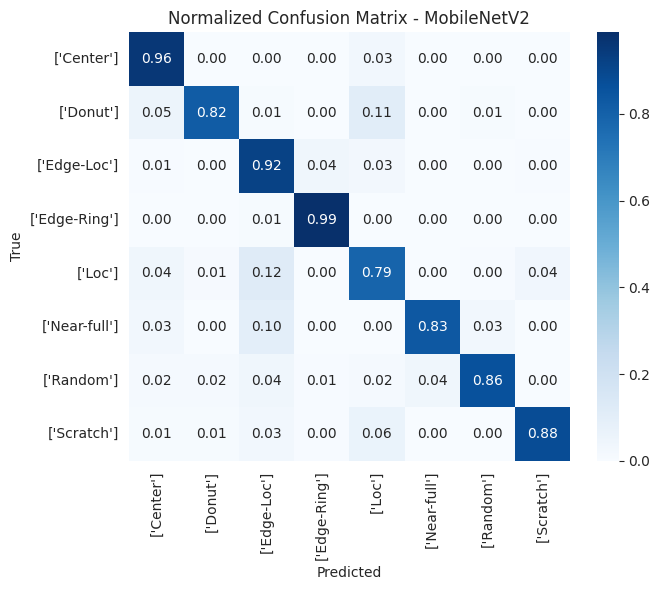


F1 Score Comparison:
      Model  Macro F1  Weighted F1
  ResNet152  0.920052     0.947577
DenseNet121  0.928146     0.945725
InceptionV3  0.916236     0.943028
 Custom CNN  0.888183     0.926672
MobileNetV2  0.883765     0.926238


In [28]:
final_results = []
all_preds = {}

for name, model in models_dict.items():
    y_t, y_p, y_prob, mf1, wf1 = evaluate_model_final(model, name, test_gen)
    all_preds[name] = (y_t, y_p, y_prob)
    final_results.append([name, mf1, wf1])

f1_df = pd.DataFrame(final_results, columns=["Model", "Macro F1", "Weighted F1"])
f1_df = f1_df.sort_values("Weighted F1", ascending=False)

print("\nF1 Score Comparison:")
print(f1_df.to_string(index=False))

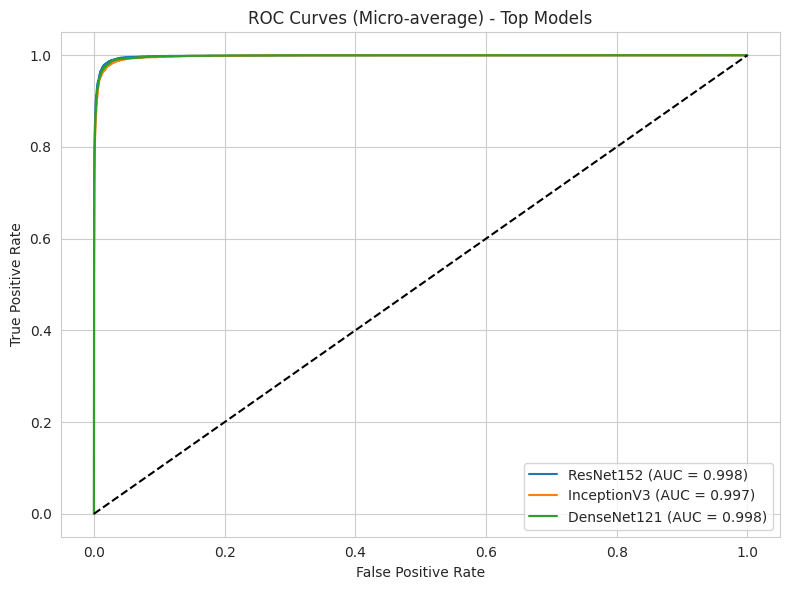

In [29]:
plt.figure(figsize=(8,6))

for name in ["ResNet152", "InceptionV3", "DenseNet121"]:
    y_true, _, y_prob = all_preds[name]
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Micro-average) - Top Models")
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
histories = {
    "Custom CNN": history_custom,
    "ResNet152": history_resnet,
    "InceptionV3": history_inception,
    "DenseNet121": history_densenet,
    "MobileNetV2": history_mobilenet
}

times = {
    "Custom CNN": time_custom/60,
    "ResNet152": time_resnet/60,
    "InceptionV3": time_inception/60,
    "DenseNet121": time_densenet/60,
    "MobileNetV2": time_mobilenet/60
}

accs = {
    "Custom CNN": acc_custom,
    "ResNet152": acc_resnet,
    "InceptionV3": acc_inception,
    "DenseNet121": acc_densenet,
    "MobileNetV2": acc_mobilenet
}

In [31]:
def measure_inference_time(model, gen, steps=20):
    import time
    t0 = time.time()
    for i in range(steps):
        X_batch, _ = gen[i]
        _ = model.predict(X_batch, verbose=0)
    t1 = time.time()
    imgs = steps * gen.batch_size
    return (t1 - t0) / imgs * 1000  

In [32]:
comparison = []

for name, model in models_dict.items():
    total_params = model.count_params()
    trainable_params = np.sum([tf.size(w).numpy() for w in model.trainable_weights])
    non_trainable = total_params - trainable_params
    size_mb = total_params * 4 / (1024**2)

    hist = histories[name]
    best_epoch = np.argmax(hist.history['val_accuracy'])

    train_acc = hist.history['accuracy'][best_epoch]
    val_acc = hist.history['val_accuracy'][best_epoch]
    gap = train_acc - val_acc

    mf1 = f1_df[f1_df['Model'] == name]['Macro F1'].values[0]
    wf1 = f1_df[f1_df['Model'] == name]['Weighted F1'].values[0]

    inf_time = measure_inference_time(model, test_gen, steps=10)

    comparison.append([
        name,
        total_params,
        trainable_params,
        non_trainable,
        size_mb,
        accs[name]*100,
        mf1,
        wf1,
        times[name],
        gap,
        inf_time
    ])

cols = [
    "Model", "Total Params", "Trainable Params", "Non-trainable Params",
    "Model Size (MB)", "Test Accuracy (%)",
    "Macro F1", "Weighted F1",
    "Training Time (min)", "Gen Gap",
    "Inference Time (ms/img)"
]

comp_df = pd.DataFrame(comparison, columns=cols)
comp_df = comp_df.sort_values("Weighted F1", ascending=False)

print("\nFULL MODEL COMPARISON")
print("="*90)
print(comp_df.to_string(index=False))


FULL MODEL COMPARISON
      Model  Total Params  Trainable Params  Non-trainable Params  Model Size (MB)  Test Accuracy (%)  Macro F1  Weighted F1  Training Time (min)   Gen Gap  Inference Time (ms/img)
  ResNet152      59426184          59273736                152448       226.692902          95.003921  0.920052     0.947577           162.907139  0.036099                65.673281
DenseNet121       7568456           7483784                 84672        28.871368          94.514108  0.928146     0.945725            60.328398  0.010382                62.056592
InceptionV3      22858024          22822568                 35456        87.196442          94.278997  0.916236     0.943028            49.560227  0.023362                38.061976
 Custom CNN       1444136           1440680                  3456         5.508942          92.672414  0.888183     0.926672            29.661745 -0.014356                11.284186
MobileNetV2       2920008           2884872                 35136       

In [33]:
pretty_df = comp_df.copy()

pretty_df["Model Size (MB)"] = pretty_df["Model Size (MB)"].map(lambda x: f"{x:.2f}")
pretty_df["Test Accuracy (%)"] = pretty_df["Test Accuracy (%)"].map(lambda x: f"{x:.2f}")
pretty_df["Macro F1"] = pretty_df["Macro F1"].map(lambda x: f"{x:.4f}")
pretty_df["Weighted F1"] = pretty_df["Weighted F1"].map(lambda x: f"{x:.4f}")
pretty_df["Training Time (min)"] = pretty_df["Training Time (min)"].map(lambda x: f"{x:.1f}")
pretty_df["Gen Gap"] = pretty_df["Gen Gap"].map(lambda x: f"{x:.4f}")
pretty_df["Inference Time (ms/img)"] = pretty_df["Inference Time (ms/img)"].map(lambda x: f"{x:.2f}")

pretty_df["Total Params"] = pretty_df["Total Params"].map(lambda x: f"{x:,}")
pretty_df["Trainable Params"] = pretty_df["Trainable Params"].map(lambda x: f"{x:,}")
pretty_df["Non-trainable Params"] = pretty_df["Non-trainable Params"].map(lambda x: f"{x:,}")

display(pretty_df)

,Model,Total Params,Trainable Params,Non-trainable Params,Model Size (MB),Test Accuracy (%),Macro F1,Weighted F1,Training Time (min),Gen Gap,Inference Time (ms/img)
1,ResNet152,59426184,59273736,152448,226.69,95.00,0.9201,0.9476,162.9,0.036099,65.67
3,DenseNet121,7568456,7483784,84672,28.87,94.51,0.9281,0.9457,60.3,0.010382,62.06
2,InceptionV3,22858024,22822568,35456,87.20,94.28,0.9162,0.9430,49.6,0.023362,38.06
0,Custom CNN,1444136,1440680,3456,5.51,92.67,0.8882,0.9267,29.7,-0.014356,11.28
4,MobileNetV2,2920008,2884872,35136,11.14,92.87,0.8838,0.9262,22.0,0.006658,22.43


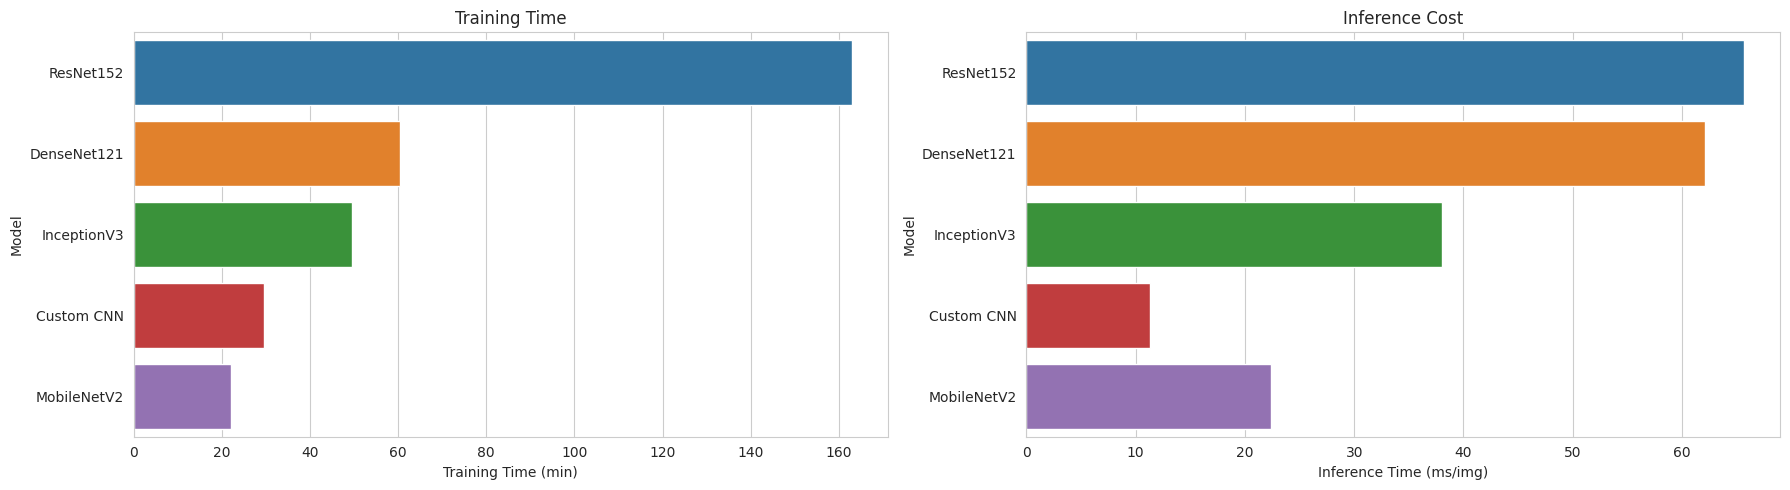

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18,5))

sns.barplot(data=comp_df, x="Training Time (min)", y="Model", ax=ax[0])
ax[0].set_title("Training Time")

sns.barplot(data=comp_df, x="Inference Time (ms/img)", y="Model", ax=ax[1])
ax[1].set_title("Inference Cost")

plt.tight_layout()
plt.show()

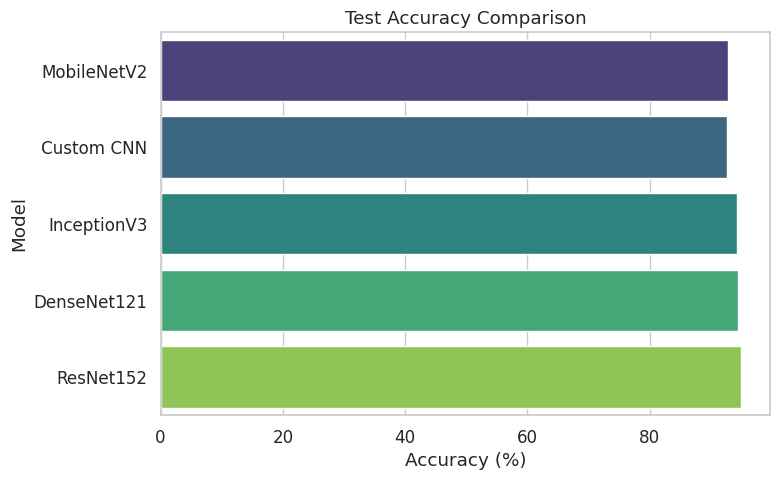

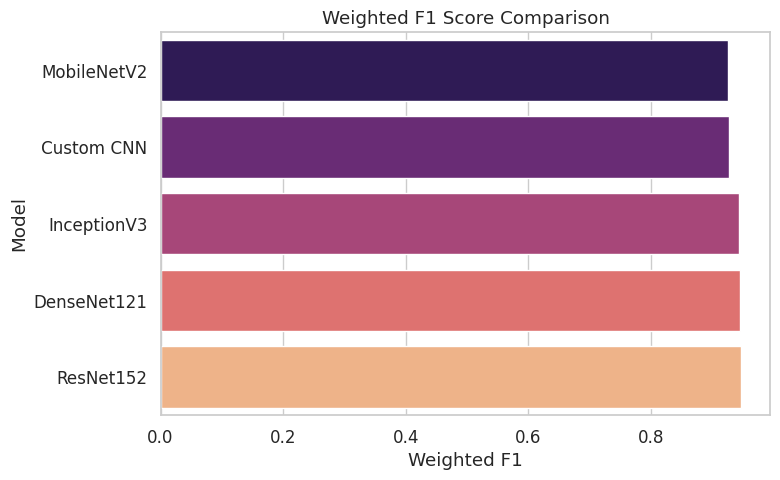

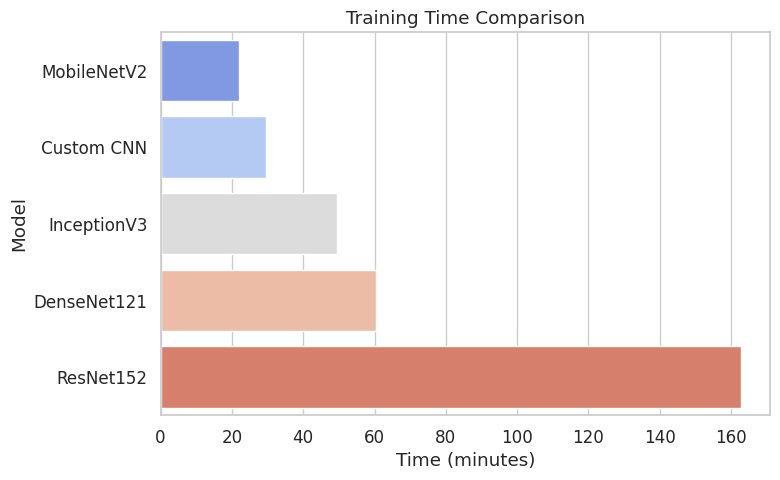

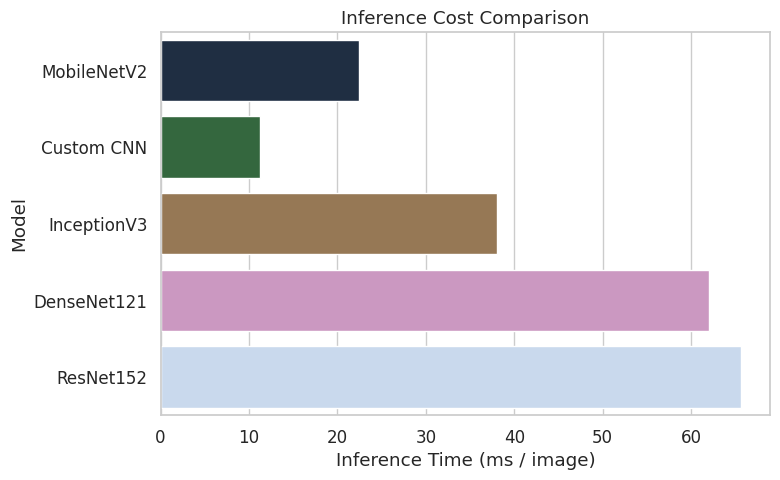

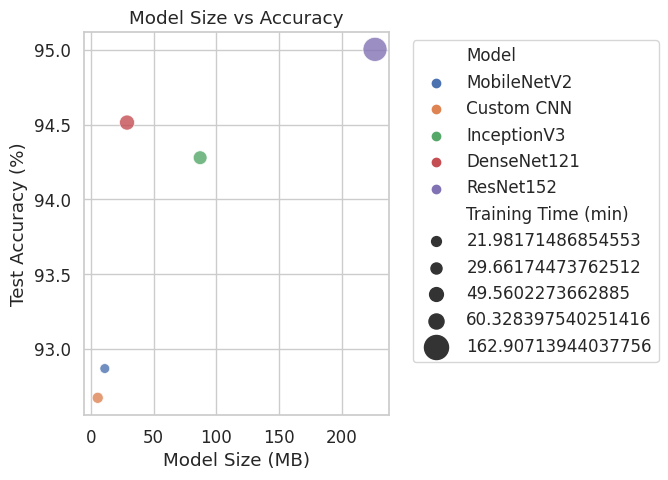

In [35]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

OUTPUT_DIR = "/kaggle/working/results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set(style="whitegrid", font_scale=1.1)

plot_df = comp_df.sort_values("Weighted F1", ascending=True)
plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="Test Accuracy (%)", y="Model", palette="viridis")
plt.title("Test Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "accuracy_comparison.png"), dpi=300)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="Weighted F1", y="Model", palette="magma")
plt.title("Weighted F1 Score Comparison")
plt.xlabel("Weighted F1")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "weighted_f1_comparison.png"), dpi=300)
plt.show()
plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="Training Time (min)", y="Model", palette="coolwarm")
plt.title("Training Time Comparison")
plt.xlabel("Time (minutes)")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "training_time_comparison.png"), dpi=300)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="Inference Time (ms/img)", y="Model", palette="cubehelix")
plt.title("Inference Cost Comparison")
plt.xlabel("Inference Time (ms / image)")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "inference_time_comparison.png"), dpi=300)
plt.show()
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=plot_df,
    x="Model Size (MB)",
    y="Test Accuracy (%)",
    size="Training Time (min)",
    hue="Model",
    sizes=(50, 300),
    alpha=0.8
)
plt.title("Model Size vs Accuracy")
plt.xlabel("Model Size (MB)")
plt.ylabel("Test Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "size_vs_accuracy.png"), dpi=300)
plt.show()